# XMM-LSS master catalogue

This notebook presents the merge of the various pristine catalogues to produce the HELP master catalogue on XMM-LSS.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
91cdb7b (Fri Oct 20 11:48:11 2017 +0100) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
candels = Table.read("{}/CANDELS.fits".format(TMP_DIR))           # 1.1
cfht_wirds = Table.read("{}/CFHT-WIRDS.fits".format(TMP_DIR))     # 1.3
cfhtls_wide = Table.read("{}/CFHTLS-WIDE.fits".format(TMP_DIR))   # 1.4a
cfhtls_deep = Table.read("{}/CFHTLS-DEEP.fits".format(TMP_DIR))   # 1.4b
#We no longer use CFHTLenS as it is the same raw data set as CFHTLS-WIDE
# cfhtlens = Table.read("{}/CFHTLENS.fits".format(TMP_DIR))         # 1.5
decals = Table.read("{}/DECaLS.fits".format(TMP_DIR))             # 1.6
servs = Table.read("{}/SERVS.fits".format(TMP_DIR))               # 1.8
swire = Table.read("{}/SWIRE.fits".format(TMP_DIR))               # 1.7
hsc_wide = Table.read("{}/HSC-WIDE.fits".format(TMP_DIR))         # 1.9a
hsc_deep = Table.read("{}/HSC-DEEP.fits".format(TMP_DIR))         # 1.9b
hsc_udeep = Table.read("{}/HSC-UDEEP.fits".format(TMP_DIR))       # 1.9c
ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))                   # 1.10
sxds = Table.read("{}/SXDS.fits".format(TMP_DIR))                 # 1.11
sparcs = Table.read("{}/SpARCS.fits".format(TMP_DIR))             # 1.12
dxs = Table.read("{}/UKIDSS-DXS.fits".format(TMP_DIR))            # 1.13
uds = Table.read("{}/UKIDSS-UDS.fits".format(TMP_DIR))            # 1.14
vipers = Table.read("{}/VIPERS.fits".format(TMP_DIR))             # 1.15
vhs = Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))             # 1.16
video = Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR))         # 1.17
viking = Table.read("{}/VISTA-VIKING.fits".format(TMP_DIR))       # 1.18

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones. We start with PanSTARRS because it coevrs the whole field.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### Add PanSTARRS

In [5]:
master_catalogue = ps1
master_catalogue['ps1_ra'].name = 'ra'
master_catalogue['ps1_dec'].name = 'dec'

### CANDELS

In [6]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(candels['candels_ra'], candels['candels_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


In [7]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, candels, "candels_ra", "candels_dec", radius=0.8*u.arcsec)

### Add CFHT-WIRDS

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfht_wirds['wirds_ra'], cfht_wirds['wirds_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


Because CFHT-WIRDS is made by merging the different bands it has a flag_merged columns which must be removed. We throw this information away because one can get back to the original object using the combined id as described in the notebook.

In [9]:
cfht_wirds['flag_merged'].name = 'flag_merged_wirds'

In [10]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, cfht_wirds, "wirds_ra", "wirds_dec", radius=0.8*u.arcsec)

### Add CFHTLS

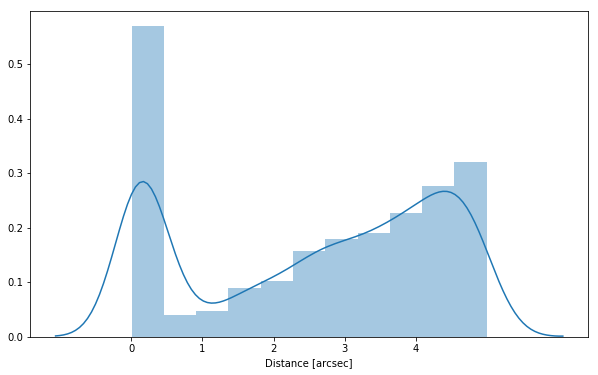

In [11]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfhtls_wide['cfhtls-wide_ra'], cfhtls_wide['cfhtls-wide_dec'])
)

In [12]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, 
                                    cfhtls_wide, 
                                    "cfhtls-wide_ra", 
                                    "cfhtls-wide_dec", 
                                    radius=0.8*u.arcsec)
master_catalogue = merge_catalogues(master_catalogue, 
                                    cfhtls_deep, 
                                    "cfhtls-deep_ra", 
                                    "cfhtls-deep_dec", 
                                    radius=0.8*u.arcsec)

### Add CFHT-LenS

CFHTLenS is no longer included since it is made from the same raw data as CFHTLS

In [13]:
"""
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(cfhtlens['cfhtlens_ra'], cfhtlens['cfhtlens_dec'])
)
"""

"\nnb_merge_dist_plot(\n    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),\n    SkyCoord(cfhtlens['cfhtlens_ra'], cfhtlens['cfhtlens_dec'])\n)\n"

In [14]:
"""# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, 
                                    cfhtlens, 
                                    "cfhtlens_ra", 
                                    "cfhtlens_dec", 
                                    radius=0.8*u.arcsec)"""

'# Given the graph above, we use 0.8 arc-second radius\nmaster_catalogue = merge_catalogues(master_catalogue, \n                                    cfhtlens, \n                                    "cfhtlens_ra", \n                                    "cfhtlens_dec", \n                                    radius=0.8*u.arcsec)'

### Add HSC-PSS

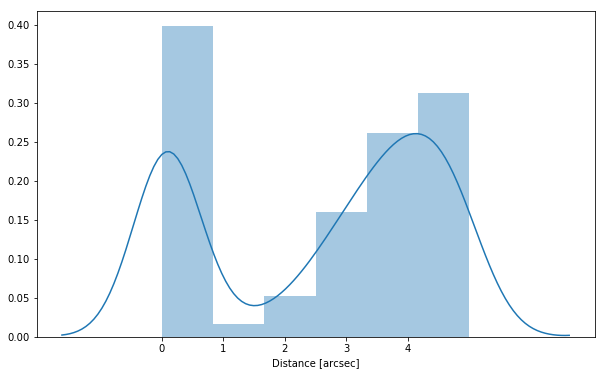

In [15]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(hsc_wide['hsc-wide_ra'], hsc_wide['hsc-wide_dec'])
)

In [16]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, hsc_wide, "hsc-wide_ra", "hsc-wide_dec", radius=0.8*u.arcsec)
master_catalogue = merge_catalogues(master_catalogue, hsc_deep, "hsc-deep_ra", "hsc-deep_dec", radius=0.8*u.arcsec)
master_catalogue = merge_catalogues(master_catalogue, hsc_udeep, "hsc-udeep_ra", "hsc-udeep_dec", radius=0.8*u.arcsec)

### Add DECaLS

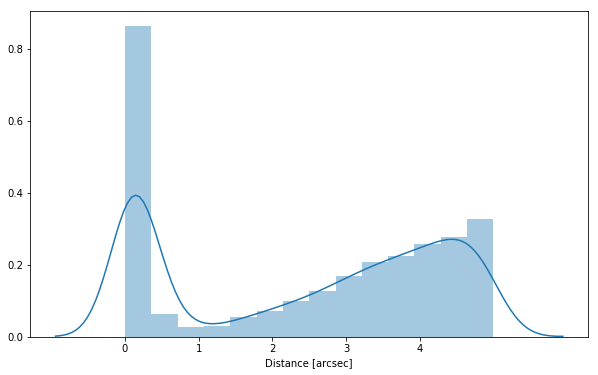

In [17]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(decals['decals_ra'], decals['decals_dec'])
)

In [18]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, decals, "decals_ra", "decals_dec", radius=0.8*u.arcsec)

### Add SpARCS

In [19]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(sparcs['sparcs_ra'], sparcs['sparcs_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


In [20]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, sparcs, "sparcs_ra", "sparcs_dec", radius=0.8*u.arcsec)

### Add SXDS

In [21]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(sxds['sxds_ra'], sxds['sxds_dec'])
)

HELP Warning: There weren't any cross matches. The two surveys probably don't overlap.


It is strange that this does not peak at zero. This is bservable in the original band cross match. It implies there is a persistent offset. Perhaps each band should be astrometrically corrected before the original merge.

In [22]:
sxds['flag_merged'].name = 'flag_merged_sxds'

In [23]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, sxds, "sxds_ra", "sxds_dec", radius=0.8*u.arcsec)

### Add DXS

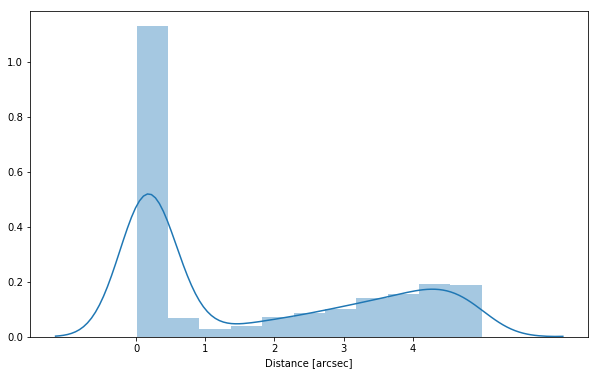

In [24]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(dxs['dxs_ra'], dxs['dxs_dec'])
)

In [25]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, dxs, "dxs_ra", "dxs_dec", radius=0.8*u.arcsec)

### Add UDS

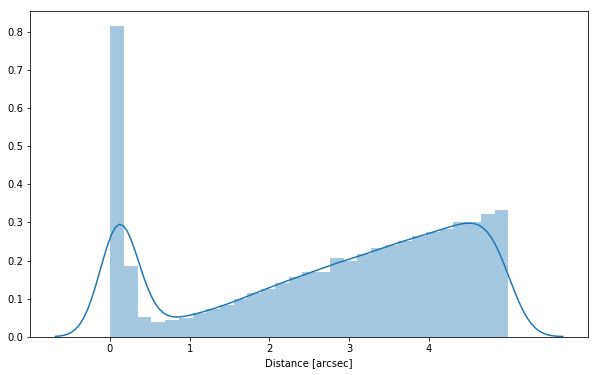

In [26]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(uds['uds_ra'], uds['uds_dec'])
)

In [27]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, uds, "uds_ra", "uds_dec", radius=0.8*u.arcsec)

### Add VIPERS

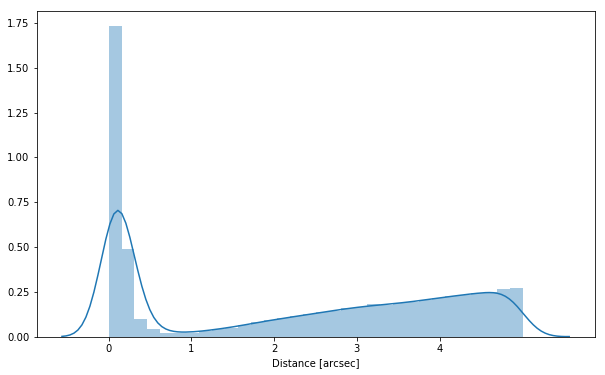

In [ ]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vipers['vipers_ra'], vipers['vipers_dec'])
)

In [ ]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, vipers, "vipers_ra", "vipers_dec", radius=0.8*u.arcsec)

### Add VIDEO

In [ ]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(video['video_ra'], video['video_dec'])
)

In [ ]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, video, "video_ra", "video_dec", radius=0.8*u.arcsec)

### Add VHS

In [ ]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vhs['vhs_ra'], vhs['vhs_dec'])
)

In [ ]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, vhs, "vhs_ra", "vhs_dec", radius=0.8*u.arcsec)

### Add VIKING

In [ ]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(viking['viking_ra'], viking['viking_dec'])
)

In [ ]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, viking, "viking_ra", "viking_dec", radius=0.8*u.arcsec)

### Add SERVS

In [ ]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(servs['servs_ra'], servs['servs_dec'])
)

In [ ]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, servs, "servs_ra", "servs_dec", radius=1.*u.arcsec)

### Add SWIRE

In [ ]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(swire['swire_ra'], swire['swire_dec'])
)

In [ ]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, swire, "swire_ra", "swire_dec", radius=1.*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [ ]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col] = master_catalogue[col].astype(float)
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [ ]:
master_catalogue[:10].show_in_notebook()

## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [ ]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

combining the flag_merged column which contains information regarding multiple associations

In [ ]:
master_catalogue['flag_merged'].name = 'flag_merged_tmp'
flag_merged_columns = [column for column in master_catalogue.colnames
                        if 'flag_merged' in column]

flag_merged_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_merged_columns:
    flag_merged_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_merged_column, name="flag_merged"))
master_catalogue.remove_columns(flag_merged_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [ ]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value. We keep trace of the origin of the stellarity.

In [ ]:
stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

print(", ".join(stellarity_columns))

In [ ]:

# We create an masked array with all the stellarities and get the maximum value, as well as its
# origin.  Some sources may not have an associated stellarity.
stellarity_array = np.array([master_catalogue[column] for column in stellarity_columns])
stellarity_array = np.ma.masked_array(stellarity_array, np.isnan(stellarity_array))

max_stellarity = np.max(stellarity_array, axis=0)
max_stellarity.fill_value = np.nan

no_stellarity_mask = max_stellarity.mask

master_catalogue.add_column(Column(data=max_stellarity.filled(), name="stellarity"))

stellarity_origin = np.full(len(master_catalogue), "NO_INFORMATION", dtype="S20")
stellarity_origin[~no_stellarity_mask] = np.array(stellarity_columns)[np.argmax(stellarity_array, axis=0)[~no_stellarity_mask]]

master_catalogue.add_column(Column(data=stellarity_origin, name="stellarity_origin"))

master_catalogue.remove_columns(stellarity_columns)

## IV - Adding E(B-V) column

In [ ]:
master_catalogue.add_column(
    ebv(master_catalogue['ra'], master_catalogue['dec'])
)

## V - Adding HELP unique identifiers and field columns

In [ ]:
master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
                                   name="help_id"))
master_catalogue.add_column(Column(np.full(len(master_catalogue), "ELAIS-N1", dtype='<U18'),
                                   name="field"))

In [ ]:
# Check that the HELP Ids are unique
if len(master_catalogue) != len(np.unique(master_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

## VI - Cross-matching with spec-z catalogue

In [ ]:
specz =  Table.read("../../dmu23/dmu23_XMM-LSS/data/XMM-LSS-specz-v2.8.fits")

In [ ]:
specz['objid'].name = 'specz_id'

In [ ]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [ ]:
master_catalogue = specz_merge(master_catalogue, specz, radius=1. * u.arcsec)

## VII - Choosing between multiple values for the same filter



### VII.a SERVS and SWIRE IRAC fluxes

Both SERVS and SWIRE provide IRAC1 and IRAC2 fluxes. SERVS is deeper but tends to under-estimate flux of bright sources (Mattia said over 2000 µJy) as illustrated by this comparison of SWIRE, SERVS, and Spitzer-EIP fluxes.

In [ ]:
seip = Table.read("../../dmu0/dmu0_SEIP/data/SEIP_XMM-LSS.fits")
seip_coords = SkyCoord(seip['ra'], seip['dec'])
idx, d2d, _ = seip_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
mask = d2d <= 2 * u.arcsec

In [ ]:
fig, ax = plt.subplots()
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_servs_irac_i1'], label="SERVS", s=2.)
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_swire_irac_i1'], label="SWIRE", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SERVS/SWIRE flux [μJy]")
ax.set_title("IRAC 1")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)
ax.plot(seip['i1_f_ap1'][mask], seip['i1_f_ap1'][mask], linewidth=.1, color="black", alpha=.5);

In [ ]:
fig, ax = plt.subplots()
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_servs_irac_i2'], label="SERVS", s=2.)
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_swire_irac_i2'], label="SWIRE", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SERVS/SWIRE flux [μJy]")
ax.set_title("IRAC 2")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)

ax.plot(seip['i1_f_ap2'][mask], seip['i1_f_ap2'][mask], linewidth=.1, color="black", alpha=.5);

When both SWIRE and SERVS fluxes are provided, we use the SERVS flux below 2000 μJy and the SWIRE flux over.

We create a table indicating for each source the origin on the IRAC1 and IRAC2 fluxes that will be saved separately.

In [ ]:
irac_origin = Table()
irac_origin.add_column(master_catalogue['help_id'])

In [ ]:
# IRAC1 aperture flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_ap_servs_irac_i1'])
has_swire = ~np.isnan(master_catalogue['f_ap_swire_irac_i1'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_ap_servs_irac_i1'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_ap_servs_irac_i1'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_ap_swire_irac_i1'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_ap_servs_irac_i1'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_ap_swire_irac_i1'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_ap_servs_irac_i1'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_ap_swire_irac_i1'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_ap_servs_irac_i1'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_ap_swire_irac_i1'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_ap_irac_i1"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_ap_irac_i1"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_ap_irac_i1"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_ap_irac_i1"))

master_catalogue.remove_columns(['f_ap_servs_irac_i1', 'f_ap_swire_irac_i1', 'ferr_ap_servs_irac_i1',
                                     'ferr_ap_swire_irac_i1', 'm_ap_servs_irac_i1', 'm_ap_swire_irac_i1',
                                     'merr_ap_servs_irac_i1', 'merr_ap_swire_irac_i1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC1_app"))

In [ ]:
# IRAC1 total flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_servs_irac_i1'])
has_swire = ~np.isnan(master_catalogue['f_swire_irac_i1'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_servs_irac_i1'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_servs_irac_i1'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_swire_irac_i1'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_servs_irac_i1'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_swire_irac_i1'][use_swire]

flag_irac_i = np.full(len(master_catalogue), False, dtype=bool)
flag_irac_i[use_servs] = master_catalogue['flag_servs_irac_i1'][use_servs]
flag_irac_i[use_swire] = master_catalogue['flag_swire_irac_i1'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_servs_irac_i1'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_swire_irac_i1'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_servs_irac_i1'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_swire_irac_i1'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_irac_i1"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_irac_i1"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_irac_i1"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_irac_i1"))
master_catalogue.add_column(Column(data=flag_irac_i, name="flag_irac_i1"))

master_catalogue.remove_columns(['f_servs_irac_i1', 'f_swire_irac_i1', 'ferr_servs_irac_i1',
                                 'ferr_swire_irac_i1', 'm_servs_irac_i1', 'flag_servs_irac_i1', 'm_swire_irac_i1',
                                 'merr_servs_irac_i1', 'merr_swire_irac_i1', 'flag_swire_irac_i1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC1_total"))

In [ ]:
# IRAC2 aperture flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_ap_servs_irac_i2'])
has_swire = ~np.isnan(master_catalogue['f_ap_swire_irac_i2'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_ap_servs_irac_i2'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_ap_servs_irac_i2'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_ap_swire_irac_i2'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_ap_servs_irac_i2'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_ap_swire_irac_i2'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_ap_servs_irac_i2'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_ap_swire_irac_i2'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_ap_servs_irac_i2'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_ap_swire_irac_i2'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_ap_irac_i2"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_ap_irac_i2"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_ap_irac_i2"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_ap_irac_i2"))

master_catalogue.remove_columns(['f_ap_servs_irac_i2', 'f_ap_swire_irac_i2', 'ferr_ap_servs_irac_i2',
                                 'ferr_ap_swire_irac_i2', 'm_ap_servs_irac_i2', 'm_ap_swire_irac_i2',
                                 'merr_ap_servs_irac_i2', 'merr_ap_swire_irac_i2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC2_app"))

In [ ]:
# IRAC2 total flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_servs_irac_i2'])
has_swire = ~np.isnan(master_catalogue['f_swire_irac_i2'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_servs_irac_i2'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac_i = np.full(len(master_catalogue), np.nan)
f_ap_irac_i[use_servs] = master_catalogue['f_servs_irac_i2'][use_servs]
f_ap_irac_i[use_swire] = master_catalogue['f_swire_irac_i2'][use_swire]

ferr_ap_irac_i = np.full(len(master_catalogue), np.nan)
ferr_ap_irac_i[use_servs] = master_catalogue['ferr_servs_irac_i2'][use_servs]
ferr_ap_irac_i[use_swire] = master_catalogue['ferr_swire_irac_i2'][use_swire]

flag_irac_i = np.full(len(master_catalogue), False, dtype=bool)
flag_irac_i[use_servs] = master_catalogue['flag_servs_irac_i2'][use_servs]
flag_irac_i[use_swire] = master_catalogue['flag_swire_irac_i2'][use_swire]

m_ap_irac_i = np.full(len(master_catalogue), np.nan)
m_ap_irac_i[use_servs] = master_catalogue['m_servs_irac_i2'][use_servs]
m_ap_irac_i[use_swire] = master_catalogue['m_swire_irac_i2'][use_swire]

merr_ap_irac_i = np.full(len(master_catalogue), np.nan)
merr_ap_irac_i[use_servs] = master_catalogue['merr_servs_irac_i2'][use_servs]
merr_ap_irac_i[use_swire] = master_catalogue['merr_swire_irac_i2'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac_i, name="f_irac_i2"))
master_catalogue.add_column(Column(data=ferr_ap_irac_i, name="ferr_irac_i2"))
master_catalogue.add_column(Column(data=m_ap_irac_i, name="m_irac_i2"))
master_catalogue.add_column(Column(data=merr_ap_irac_i, name="merr_irac_i2"))
master_catalogue.add_column(Column(data=flag_irac_i, name="flag_irac_i2"))

master_catalogue.remove_columns(['f_servs_irac_i2', 'f_swire_irac_i2', 'ferr_servs_irac_i2',
                                 'ferr_swire_irac_i2', 'm_servs_irac_i2', 'flag_servs_irac_i2', 'm_swire_irac_i2',
                                 'merr_servs_irac_i2', 'merr_swire_irac_i2', 'flag_swire_irac_i2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC2_total"))

In [ ]:
irac_origin.write("{}/elais-n1_irac_i_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX))

### VII.b SpARCS, CFHTLS, CFHT-WIRDS amd CFHTLenS: CFHT Megacam fluxes

According to Mattia CFHTLenS is built on the same data as CFHTLS-WIDE and should not be included. I have therefore excluded it from the merge above.

CFHTLS-DEEP is prefferred to CFHTLS-WIDE which is prefferred to SpARCS

|             |                  |
|-------------|------------------|
| CFHTLS-WIDE | u, g, r, i, z    |
| CFHTLS-DEEP | u, g, r, i, z, y |
| SpARCS      | u, g, r, z, y    |


In [ ]:
megacam_origin = Table()
megacam_origin.add_column(master_catalogue['help_id'])

In [ ]:
megacam_stats = Table()
megacam_stats.add_column(Column(data=['u','g','r','i','z','y'], name="Band"))
for col in ["CFHTLS-DEEP", "CFHTLS-WIDE", "SpARCS"]:
    megacam_stats.add_column(Column(data=np.full(6, 0), name="{}".format(col)))
    megacam_stats.add_column(Column(data=np.full(6, 0), name="use {}".format(col)))
    megacam_stats.add_column(Column(data=np.full(6, 0), name="{} ap".format(col)))
    megacam_stats.add_column(Column(data=np.full(6, 0), name="use {} ap".format(col)))
    

In [ ]:

megacam_bands = ['u','g','r','i','z','y'] # Lowercase naming convention (k is Ks)
for band in megacam_bands:

    # Megacam total flux 
    has_cfhtls_deep = ~np.isnan(master_catalogue['f_cfhtls-deep_' + band])
    if band == 'y':
        has_cfhtls_wide = np.full(len(master_catalogue), False)
    else:
        has_cfhtls_wide = ~np.isnan(master_catalogue['f_cfhtls-wide_' + band])
    if band == 'i':
        has_sparcs = np.full(len(master_catalogue), False)
    else:
        has_sparcs = ~np.isnan(master_catalogue['f_sparcs_' + band])
    

    use_cfhtls_deep = has_cfhtls_deep 
    use_cfhtls_wide = has_cfhtls_wide & ~has_cfhtls_deep
    use_sparcs = has_sparcs & ~has_cfhtls_wide & ~has_cfhtls_deep

    f_megacam = np.full(len(master_catalogue), np.nan)
    f_megacam[use_cfhtls_deep] = master_catalogue['f_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        f_megacam[use_cfhtls_wide] = master_catalogue['f_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        f_megacam[use_sparcs] = master_catalogue['f_sparcs_' + band][use_sparcs]

    ferr_megacam = np.full(len(master_catalogue), np.nan)
    ferr_megacam[use_cfhtls_deep] = master_catalogue['ferr_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        ferr_megacam[use_cfhtls_wide] = master_catalogue['ferr_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        ferr_megacam[use_sparcs] = master_catalogue['ferr_sparcs_' + band][use_sparcs]
    
    m_megacam = np.full(len(master_catalogue), np.nan)
    m_megacam[use_cfhtls_deep] = master_catalogue['m_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        m_megacam[use_cfhtls_wide] = master_catalogue['m_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        m_megacam[use_sparcs] = master_catalogue['m_sparcs_' + band][use_sparcs]

    merr_megacam = np.full(len(master_catalogue), np.nan)
    merr_megacam[use_cfhtls_deep] = master_catalogue['merr_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        merr_megacam[use_cfhtls_wide] = master_catalogue['merr_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        merr_megacam[use_sparcs] = master_catalogue['merr_sparcs_' + band][use_sparcs]

    flag_megacam = np.full(len(master_catalogue), False, dtype=bool)
    flag_megacam[use_cfhtls_deep] = master_catalogue['flag_cfhtls-deep_' + band][use_cfhtls_deep]
    if not (band == 'y'):
        flag_megacam[use_cfhtls_wide] = master_catalogue['flag_cfhtls-wide_' + band][use_cfhtls_wide]
    if not (band == 'i'):
        flag_megacam[use_sparcs] = master_catalogue['flag_sparcs_' + band][use_sparcs]

    master_catalogue.add_column(Column(data=f_megacam, name="f_megacam_" + band))
    master_catalogue.add_column(Column(data=ferr_megacam, name="ferr_megacam_" + band))
    master_catalogue.add_column(Column(data=m_megacam, name="m_megacam_" + band))
    master_catalogue.add_column(Column(data=merr_megacam, name="merr_megacam_" + band))
    master_catalogue.add_column(Column(data=flag_megacam, name="flag_megacam_" + band))

    old_cfhtls_deep_columns = ['f_cfhtls-deep_' + band,
                               'ferr_cfhtls-deep_' + band,
                               'm_cfhtls-deep_' + band, 
                               'merr_cfhtls-deep_' + band,
                               'flag_cfhtls-deep_' + band]
    old_cfhtls_wide_columns = ['f_cfhtls-wide_' + band,
                               'ferr_cfhtls-wide_' + band,
                               'm_cfhtls-wide_' + band, 
                               'merr_cfhtls-wide_' + band,
                               'flag_cfhtls-wide_' + band]
    old_sparcs_columns =      ['f_sparcs_' + band,
                               'ferr_sparcs_' + band,
                               'm_sparcs_' + band, 
                               'merr_sparcs_' + band,
                               'flag_sparcs_' + band]
    
    if (band == 'i'):
        old_columns = old_cfhtls_deep_columns + old_cfhtls_wide_columns
    elif (band == 'y'):
        old_columns = old_cfhtls_deep_columns + old_sparcs_columns
    else:
        old_columns = old_cfhtls_deep_columns + old_cfhtls_wide_columns + old_sparcs_columns
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_cfhtls_deep] = "CFHTLS-DEEP"
    origin[use_cfhtls_wide] = "CFHTLS-WIDE"
    origin[use_sparcs] = "SpARCS"
    
    megacam_origin.add_column(Column(data=origin, name= 'f_megacam_' + band ))
    
    # Megacam aperture flux 
    has_ap_cfhtls_deep = ~np.isnan(master_catalogue['f_ap_cfhtls-deep_' + band])
    if band == 'y':
        has_ap_cfhtls_wide = np.full(len(master_catalogue), False)
    else:
        has_ap_cfhtls_wide = ~np.isnan(master_catalogue['f_ap_cfhtls-wide_' + band])
    if band == 'i':
        has_ap_sparcs = np.full(len(master_catalogue), False)
    else:
        has_ap_sparcs = ~np.isnan(master_catalogue['f_ap_sparcs_' + band])
    

    use_ap_cfhtls_deep = has_ap_cfhtls_deep 
    use_ap_cfhtls_wide = has_ap_cfhtls_wide & ~has_ap_cfhtls_deep
    use_ap_sparcs = has_ap_sparcs & ~has_ap_cfhtls_wide & ~has_ap_cfhtls_deep

    f_ap_megacam = np.full(len(master_catalogue), np.nan)
    f_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['f_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        f_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['f_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        f_ap_megacam[use_ap_sparcs] = master_catalogue['f_ap_sparcs_' + band][use_ap_sparcs]

    ferr_ap_megacam = np.full(len(master_catalogue), np.nan)
    ferr_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['ferr_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        ferr_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['ferr_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        ferr_ap_megacam[use_ap_sparcs] = master_catalogue['ferr_ap_sparcs_' + band][use_ap_sparcs]
    
    m_ap_megacam = np.full(len(master_catalogue), np.nan)
    m_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['m_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        m_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['m_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        m_ap_megacam[use_ap_sparcs] = master_catalogue['m_ap_sparcs_' + band][use_ap_sparcs]

    merr_ap_megacam = np.full(len(master_catalogue), np.nan)
    merr_ap_megacam[use_ap_cfhtls_deep] = master_catalogue['merr_ap_cfhtls-deep_' + band][use_ap_cfhtls_deep]
    if not (band == 'y'):
        merr_ap_megacam[use_ap_cfhtls_wide] = master_catalogue['merr_ap_cfhtls-wide_' + band][use_ap_cfhtls_wide]
    if not (band == 'i'):
        merr_ap_megacam[use_ap_sparcs] = master_catalogue['merr_ap_sparcs_' + band][use_ap_sparcs]



    master_catalogue.add_column(Column(data=f_ap_megacam, name="f_ap_megacam_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_megacam, name="ferr_ap_megacam_" + band))
    master_catalogue.add_column(Column(data=m_ap_megacam, name="m_ap_megacam_" + band))
    master_catalogue.add_column(Column(data=merr_ap_megacam, name="merr_ap_megacam_" + band))


    old_ap_cfhtls_deep_columns = ['f_ap_cfhtls-deep_' + band,
                               'ferr_ap_cfhtls-deep_' + band,
                               'm_ap_cfhtls-deep_' + band, 
                               'merr_ap_cfhtls-deep_' + band]
    old_ap_cfhtls_wide_columns = ['f_ap_cfhtls-wide_' + band,
                               'ferr_ap_cfhtls-wide_' + band,
                               'm_ap_cfhtls-wide_' + band, 
                               'merr_ap_cfhtls-wide_' + band]
    old_ap_sparcs_columns =      ['f_ap_sparcs_' + band,
                               'ferr_ap_sparcs_' + band,
                               'm_ap_sparcs_' + band, 
                               'merr_ap_sparcs_' + band]
    
    if (band == 'i'):
        old_ap_columns = old_ap_cfhtls_deep_columns + old_ap_cfhtls_wide_columns
    elif (band == 'y'):
        old_ap_columns = old_ap_cfhtls_deep_columns + old_ap_sparcs_columns
    else:
        old_ap_columns = old_ap_cfhtls_deep_columns + old_ap_cfhtls_wide_columns + old_ap_sparcs_columns
    master_catalogue.remove_columns(old_ap_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_cfhtls_deep] = "CFHTLS-DEEP"
    origin_ap[use_ap_cfhtls_wide] = "CFHTLS-WIDE"
    origin_ap[use_ap_sparcs] = "SpARCS"
    
    megacam_origin.add_column(Column(data=origin_ap, name= 'f_ap_megacam_' + band ))
    

   
    megacam_stats['CFHTLS-DEEP'][megacam_stats['Band'] == band] = np.sum(has_cfhtls_deep)
    megacam_stats['CFHTLS-WIDE'][megacam_stats['Band'] == band] = np.sum(has_cfhtls_wide)
    megacam_stats['SpARCS'][megacam_stats['Band'] == band] = np.sum(has_sparcs)
    megacam_stats['use CFHTLS-DEEP'][megacam_stats['Band'] == band] = np.sum(use_cfhtls_deep)
    megacam_stats['use CFHTLS-WIDE'][megacam_stats['Band'] == band] = np.sum(use_cfhtls_wide)
    megacam_stats['use SpARCS'][megacam_stats['Band'] == band] = np.sum(use_sparcs)
    megacam_stats['CFHTLS-DEEP ap'][megacam_stats['Band'] == band] = np.sum(has_ap_cfhtls_deep)
    megacam_stats['CFHTLS-WIDE ap'][megacam_stats['Band'] == band] = np.sum(has_ap_cfhtls_wide)
    megacam_stats['SpARCS ap'][megacam_stats['Band'] == band] = np.sum(has_ap_sparcs)
    megacam_stats['use CFHTLS-DEEP ap'][megacam_stats['Band'] == band] = np.sum(use_ap_cfhtls_deep)
    megacam_stats['use CFHTLS-WIDE ap'][megacam_stats['Band'] == band] = np.sum(use_ap_cfhtls_wide)
    megacam_stats['use SpARCS ap'][megacam_stats['Band'] == band] = np.sum(use_ap_sparcs)

In [ ]:
megacam_stats.show_in_notebook()

In [ ]:
megacam_origin.write("{}/xmm-lss_megacam_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX))

### VII.c VISTA VIDEO, VHS, and VIKING: UKIDSS fluxes

According to Mattia Vacari VIDEO is deeper than VIKING which is deeper than VHS

In [ ]:
vista_origin = Table()
vista_origin.add_column(master_catalogue['help_id'])

In [ ]:
vista_stats = Table()
vista_stats.add_column(Column(data=['y','j','h','k','z'], name="Band"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VIDEO"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VIKING"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VHS"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VIDEO"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VIKING"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VHS"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VIDEO ap"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VIKING ap"))
vista_stats.add_column(Column(data=np.full(5, 0), name="VHS ap"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VIDEO ap"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VIKING ap"))
vista_stats.add_column(Column(data=np.full(5, 0), name="use VHS ap"))

In [ ]:

vista_bands = ['y','j','h','k','z'] # Lowercase naming convention (k is Ks)
for band in vista_bands:
    #print('For VISTA band ' + band + ':')
    # VISTA total flux 
    has_video = ~np.isnan(master_catalogue['f_video_' + band])
    has_viking = ~np.isnan(master_catalogue['f_viking_' + band])
    if band == 'z':
        has_vhs = np.full(len(master_catalogue), False)
    else:
        has_vhs = ~np.isnan(master_catalogue['f_vhs_' + band])
    

    #print("{} sources with VIDEO flux".format(np.sum(has_video)))
    #print("{} sources with VIKING flux".format(np.sum(has_viking)))
    #print("{} sources with VHS flux".format(np.sum(has_vhs)))
    #print("{} sources with VIDEO, VIKING, and VHS flux".format(np.sum(has_video & has_viking & has_vhs)))


    use_video = has_video 
    use_viking = has_viking & ~has_video
    use_vhs = has_vhs & ~has_video & ~has_viking

    #print("{} sources for which we use VIDEO".format(np.sum(use_video)))
    #print("{} sources for which we use VIKING".format(np.sum(use_viking)))
    #print("{} sources for which we use VHS".format(np.sum(use_vhs)))

    f_vista = np.full(len(master_catalogue), np.nan)
    f_vista[use_video] = master_catalogue['f_video_' + band][use_video]
    f_vista[use_viking] = master_catalogue['f_viking_' + band][use_viking]
    if not (band == 'z'):
        f_vista[use_vhs] = master_catalogue['f_vhs_' + band][use_vhs]

    ferr_vista = np.full(len(master_catalogue), np.nan)
    ferr_vista[use_video] = master_catalogue['ferr_video_' + band][use_video]
    ferr_vista[use_viking] = master_catalogue['ferr_viking_' + band][use_viking]
    if not (band == 'z'):
        ferr_vista[use_vhs] = master_catalogue['ferr_vhs_' + band][use_vhs]
    
    m_vista = np.full(len(master_catalogue), np.nan)
    m_vista[use_video] = master_catalogue['m_video_' + band][use_video]
    m_vista[use_viking] = master_catalogue['m_viking_' + band][use_viking]
    if not (band == 'z'):
        m_vista[use_vhs] = master_catalogue['m_vhs_' + band][use_vhs]

    merr_vista = np.full(len(master_catalogue), np.nan)
    merr_vista[use_video] = master_catalogue['merr_video_' + band][use_video]
    merr_vista[use_viking] = master_catalogue['merr_viking_' + band][use_viking]
    if not (band == 'z'):
        merr_vista[use_vhs] = master_catalogue['merr_vhs_' + band][use_vhs]

    flag_vista = np.full(len(master_catalogue), False, dtype=bool)
    flag_vista[use_video] = master_catalogue['flag_video_' + band][use_video]
    flag_vista[use_viking] = master_catalogue['flag_viking_' + band][use_viking]
    if not (band == 'z'):
        flag_vista[use_vhs] = master_catalogue['flag_vhs_' + band][use_vhs]

    master_catalogue.add_column(Column(data=f_vista, name="f_vista_" + band))
    master_catalogue.add_column(Column(data=ferr_vista, name="ferr_vista_" + band))
    master_catalogue.add_column(Column(data=m_vista, name="m_vista_" + band))
    master_catalogue.add_column(Column(data=merr_vista, name="merr_vista_" + band))
    master_catalogue.add_column(Column(data=flag_vista, name="flag_vista_" + band))

    old_video_and_viking_columns = ['f_video_' + band, 
                                     'f_viking_' + band, 
                                     'ferr_video_' + band,
                                     'ferr_viking_' + band, 
                                     'm_video_' + band, 
                                     'm_viking_' + band, 
                                     'merr_video_' + band,
                                     'merr_viking_' + band,
                                     'flag_video_' + band, 
                                     'flag_viking_' + band]
    old_vhs_columns = ['f_vhs_' + band, 
                       'ferr_vhs_' + band, 
                       'm_vhs_' + band, 
                       'merr_vhs_' + band,
                       'flag_vhs_' + band]
    
    if not (band == 'z'):
        old_columns = old_video_and_viking_columns + old_vhs_columns
    else:
        old_columns = old_video_and_viking_columns
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_video] = "VIDEO"
    origin[use_viking] = "VIKING"
    origin[use_vhs] = "VHS"
    
    vista_origin.add_column(Column(data=origin, name= 'f_vista_' + band ))
    
    
    
    # VISTA Aperture flux
    has_ap_video = ~np.isnan(master_catalogue['f_ap_video_' + band])
    has_ap_viking = ~np.isnan(master_catalogue['f_ap_viking_' + band])
    if (band == 'z'):
        has_ap_vhs = np.full(len(master_catalogue), False)
    else:
        has_ap_vhs = ~np.isnan(master_catalogue['f_ap_vhs_' + band])

    #print("{} sources with VIDEO aperture flux".format(np.sum(has_ap_video)))
    #print("{} sources with VIKING aperture flux".format(np.sum(has_ap_viking)))
    #print("{} sources with VHS aperture flux".format(np.sum(has_ap_vhs)))
    #print("{} sources with VIDEO, VIKING and VHS aperture flux".format(np.sum(has_ap_video & has_ap_viking & has_ap_vhs)))

    use_ap_video = has_ap_video 
    use_ap_viking = has_ap_viking & ~has_ap_video
    use_ap_vhs = has_ap_vhs & ~has_ap_video & ~has_ap_viking

    #print("{} sources for which we use VIDEO aperture fluxes".format(np.sum(use_ap_video)))
    #print("{} sources for which we use VIKING aperture fluxes".format(np.sum(use_ap_viking)))
    #print("{} sources for which we use VHS aperture fluxes".format(np.sum(use_ap_vhs)))

    f_ap_vista = np.full(len(master_catalogue), np.nan)
    f_ap_vista[use_ap_video] = master_catalogue['f_ap_video_' + band][use_ap_video]
    f_ap_vista[use_ap_viking] = master_catalogue['f_ap_viking_' + band][use_ap_viking]
    if not (band == 'z'):
        f_ap_vista[use_ap_vhs] = master_catalogue['f_ap_vhs_' + band][use_ap_vhs]

    ferr_ap_vista = np.full(len(master_catalogue), np.nan)
    ferr_ap_vista[use_ap_video] = master_catalogue['ferr_ap_video_' + band][use_ap_video]
    ferr_ap_vista[use_ap_viking] = master_catalogue['ferr_ap_viking_' + band][use_ap_viking]
    if not (band == 'z'):
        ferr_ap_vista[use_ap_vhs] = master_catalogue['ferr_ap_vhs_' + band][use_ap_vhs]
    
    m_ap_vista = np.full(len(master_catalogue), np.nan)
    m_ap_vista[use_ap_video] = master_catalogue['m_ap_video_' + band][use_ap_video]
    m_ap_vista[use_ap_viking] = master_catalogue['m_ap_viking_' + band][use_ap_viking]
    if not (band == 'z'):
        m_ap_vista[use_ap_vhs] = master_catalogue['m_ap_vhs_' + band][use_ap_vhs]

    merr_ap_vista = np.full(len(master_catalogue), np.nan)
    merr_ap_vista[use_ap_video] = master_catalogue['merr_ap_video_' + band][use_ap_video]
    merr_ap_vista[use_ap_viking] = master_catalogue['merr_ap_viking_' + band][use_ap_viking]
    if not (band == 'z'):
        merr_ap_vista[use_ap_vhs] = master_catalogue['merr_ap_vhs_' + band][use_ap_vhs]


    master_catalogue.add_column(Column(data=f_ap_vista, name="f_ap_vista_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_vista, name="ferr_ap_vista_" + band))
    master_catalogue.add_column(Column(data=m_ap_vista, name="m_ap_vista_" + band))
    master_catalogue.add_column(Column(data=merr_vista, name="merr_ap_vista_" + band))


    ap_old_video_and_viking_columns = ['f_ap_video_' + band, 
                                     'f_ap_viking_' + band, 
                                     'ferr_ap_video_' + band,
                                     'ferr_ap_viking_' + band, 
                                     'm_ap_video_' + band, 
                                     'm_ap_viking_' + band, 
                                     'merr_ap_video_' + band,
                                     'merr_ap_viking_' + band]
    ap_old_vhs_columns = ['f_ap_vhs_' + band, 
                       'ferr_ap_vhs_' + band, 
                       'm_ap_vhs_' + band, 
                       'merr_ap_vhs_' + band]
    
    if not (band == 'z'):
        ap_old_columns = ap_old_video_and_viking_columns + ap_old_vhs_columns
    else:
        ap_old_columns = ap_old_video_and_viking_columns
    master_catalogue.remove_columns(ap_old_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_video] = "VIDEO"
    origin_ap[use_ap_viking] = "VIKING"
    origin_ap[use_ap_vhs] = "VHS"
    
    vista_origin.add_column(Column(data=origin_ap, name= 'f_ap_vista_' + band ))
    
    vista_stats['VIDEO'][vista_stats['Band'] == band] = np.sum(has_video)
    vista_stats['VIKING'][vista_stats['Band'] == band] = np.sum(has_viking)
    vista_stats['VHS'][vista_stats['Band'] == band] = np.sum(has_vhs)
    vista_stats['use VIDEO'][vista_stats['Band'] == band] = np.sum(use_video)
    vista_stats['use VIKING'][vista_stats['Band'] == band] = np.sum(use_viking)
    vista_stats['use VHS'][vista_stats['Band'] == band] = np.sum(use_vhs)
    vista_stats['VIDEO ap'][vista_stats['Band'] == band] = np.sum(has_ap_video)
    vista_stats['VIKING ap'][vista_stats['Band'] == band] = np.sum(has_ap_viking)
    vista_stats['VHS ap'][vista_stats['Band'] == band] = np.sum(has_ap_vhs)
    vista_stats['use VIDEO ap'][vista_stats['Band'] == band] = np.sum(use_ap_video)
    vista_stats['use VIKING ap'][vista_stats['Band'] == band] = np.sum(use_ap_viking)
    vista_stats['use VHS ap'][vista_stats['Band'] == band] = np.sum(use_ap_vhs)

### Vista origin overview
For each band show how many objects have fluxes from each survey for both total and aperture photometries.

In [ ]:
vista_stats.show_in_notebook()

In [ ]:
vista_origin.write("{}/xmm-lss_vista_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX))

### VII. d UKIDSS DXS and UDS

There is no overlap between UDS and DXS so I have named the columns 'ukidss' in the pristine catalogue production stage.

### VII. e HSC wide, deep and udeep
Here we straightforwardly take the deepest

| Survey      | Bands observed   |
|-------------|------------------|
| HSC-WIDE    | grizy            |
| HSC-DEEP    | grizy            |
| HSC-UDEEP   | grizy n921 n816  |

In [ ]:
suprime_origin = Table()
suprime_origin.add_column(master_catalogue['help_id'])

In [ ]:
suprime_stats = Table()
suprime_stats.add_column(Column(data=['g','r','i','z','y'], name="Band"))
for col in ["HSC-UDEEP",  "HSC-DEEP", "HSC-WIDE"]:
    suprime_stats.add_column(Column(data=np.full(5, 0), name="{}".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="use {}".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="{} ap".format(col)))
    suprime_stats.add_column(Column(data=np.full(5, 0), name="use {} ap".format(col)))
    
#n921 and n816 only in udeep so we can just rename those columns
for col in master_catalogue.colnames:
    if ('n921' in col) or ('n816' in col):
        master_catalogue[col].name = col.replace('hsc-udeep', 'suprime')

In [ ]:
suprime_bands = ['g','r','i','z','y'] # Lowercase naming convention (k is Ks)
for band in suprime_bands:

    # Suprime total flux 
    has_hsc_udeep = ~np.isnan(master_catalogue['f_hsc-udeep_' + band])
    has_hsc_deep  = ~np.isnan(master_catalogue['f_hsc-deep_' + band])
    has_hsc_wide  = ~np.isnan(master_catalogue['f_hsc-wide_' + band])
    

    use_hsc_udeep = has_hsc_udeep
    use_hsc_deep = has_hsc_deep & ~has_hsc_udeep
    use_hsc_wide = has_hsc_wide & ~has_hsc_deep & ~has_hsc_udeep

    f_suprime = np.full(len(master_catalogue), np.nan)
    f_suprime[use_hsc_udeep] = master_catalogue['f_hsc-udeep_' + band][use_hsc_udeep]
    f_suprime[use_hsc_deep] = master_catalogue['f_hsc-deep_' + band][use_hsc_deep]
    f_suprime[use_hsc_wide] = master_catalogue['f_hsc-wide_' + band][use_hsc_wide]

    ferr_suprime = np.full(len(master_catalogue), np.nan)
    ferr_suprime[use_hsc_udeep] = master_catalogue['ferr_hsc-udeep_' + band][use_hsc_udeep]
    ferr_suprime[use_hsc_deep] = master_catalogue['ferr_hsc-deep_' + band][use_hsc_deep]
    ferr_suprime[use_hsc_wide] = master_catalogue['ferr_hsc-wide_' + band][use_hsc_wide]
    
    m_suprime = np.full(len(master_catalogue), np.nan)
    m_suprime[use_hsc_udeep] = master_catalogue['m_hsc-udeep_' + band][use_hsc_udeep]
    m_suprime[use_hsc_deep] = master_catalogue['m_hsc-deep_' + band][use_hsc_deep]
    m_suprime[use_hsc_wide] = master_catalogue['m_hsc-wide_' + band][use_hsc_wide]

    merr_suprime = np.full(len(master_catalogue), np.nan)
    merr_suprime[use_hsc_udeep] = master_catalogue['merr_hsc-udeep_' + band][use_hsc_udeep]
    merr_suprime[use_hsc_deep] = master_catalogue['merr_hsc-deep_' + band][use_hsc_deep]
    merr_suprime[use_hsc_wide] = master_catalogue['merr_hsc-wide_' + band][use_hsc_wide]

    flag_suprime = np.full(len(master_catalogue), False, dtype=bool)
    flag_suprime[use_hsc_udeep] = master_catalogue['flag_hsc-udeep_' + band][use_hsc_udeep]
    flag_suprime[use_hsc_deep] = master_catalogue['flag_hsc-deep_' + band][use_hsc_deep]
    flag_suprime[use_hsc_wide] = master_catalogue['flag_hsc-wide_' + band][use_hsc_wide]

    master_catalogue.add_column(Column(data=f_suprime, name="f_suprime_" + band))
    master_catalogue.add_column(Column(data=ferr_suprime, name="ferr_suprime_" + band))
    master_catalogue.add_column(Column(data=m_suprime, name="m_suprime_" + band))
    master_catalogue.add_column(Column(data=merr_suprime, name="merr_suprime_" + band))
    master_catalogue.add_column(Column(data=flag_suprime, name="flag_suprime_" + band))

    old_hsc_udeep_columns = ['f_hsc-udeep_' + band,
                               'ferr_hsc-udeep_' + band,
                               'm_hsc-udeep_' + band, 
                               'merr_hsc-udeep_' + band,
                               'flag_hsc-udeep_' + band]
    old_hsc_deep_columns = ['f_hsc-deep_' + band,
                               'ferr_hsc-deep_' + band,
                               'm_hsc-deep_' + band, 
                               'merr_hsc-deep_' + band,
                               'flag_hsc-deep_' + band]
    old_hsc_wide_columns =      ['f_hsc-wide_' + band,
                               'ferr_hsc-wide_' + band,
                               'm_hsc-wide_' + band, 
                               'merr_hsc-wide_' + band,
                               'flag_hsc-wide_' + band]
    
    old_columns = old_hsc_udeep_columns + old_hsc_deep_columns + old_hsc_wide_columns
    master_catalogue.remove_columns(old_columns)

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_hsc_udeep] = "HSC-UDEEP"
    origin[use_hsc_deep] = "HSC-DEEP"
    origin[use_hsc_wide] = "HSC-WIDE"
    
    suprime_origin.add_column(Column(data=origin, name= 'f_suprime_' + band ))
    
  
    # Suprime aperture flux 
    has_ap_hsc_udeep = ~np.isnan(master_catalogue['f_ap_hsc-udeep_' + band])
    has_ap_hsc_deep  = ~np.isnan(master_catalogue['f_ap_hsc-deep_' + band])
    has_ap_hsc_wide  = ~np.isnan(master_catalogue['f_ap_hsc-wide_' + band])
    

    use_ap_hsc_udeep = has_ap_hsc_udeep
    use_ap_hsc_deep = has_ap_hsc_deep & ~has_ap_hsc_udeep
    use_ap_hsc_wide = has_ap_hsc_wide & ~has_ap_hsc_deep & ~has_ap_hsc_udeep

    f_ap_suprime = np.full(len(master_catalogue), np.nan)
    f_ap_suprime[use_ap_hsc_udeep] = master_catalogue['f_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    f_ap_suprime[use_ap_hsc_deep] = master_catalogue['f_ap_hsc-deep_' + band][use_ap_hsc_deep]
    f_ap_suprime[use_ap_hsc_wide] = master_catalogue['f_ap_hsc-wide_' + band][use_ap_hsc_wide]

    ferr_ap_suprime = np.full(len(master_catalogue), np.nan)
    ferr_ap_suprime[use_ap_hsc_udeep] = master_catalogue['ferr_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    ferr_ap_suprime[use_ap_hsc_deep] = master_catalogue['ferr_ap_hsc-deep_' + band][use_ap_hsc_deep]
    ferr_ap_suprime[use_ap_hsc_wide] = master_catalogue['ferr_ap_hsc-wide_' + band][use_ap_hsc_wide]
    
    m_ap_suprime = np.full(len(master_catalogue), np.nan)
    m_ap_suprime[use_ap_hsc_udeep] = master_catalogue['m_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    m_ap_suprime[use_ap_hsc_deep] = master_catalogue['m_ap_hsc-deep_' + band][use_ap_hsc_deep]
    m_ap_suprime[use_ap_hsc_wide] = master_catalogue['m_ap_hsc-wide_' + band][use_ap_hsc_wide]

    merr_ap_suprime = np.full(len(master_catalogue), np.nan)
    merr_ap_suprime[use_ap_hsc_udeep] = master_catalogue['merr_ap_hsc-udeep_' + band][use_ap_hsc_udeep]
    merr_ap_suprime[use_ap_hsc_deep] = master_catalogue['merr_ap_hsc-deep_' + band][use_ap_hsc_deep]
    merr_ap_suprime[use_ap_hsc_wide] = master_catalogue['merr_ap_hsc-wide_' + band][use_ap_hsc_wide]


    master_catalogue.add_column(Column(data=f_ap_suprime, name="f_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_suprime, name="ferr_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=m_ap_suprime, name="m_ap_suprime_" + band))
    master_catalogue.add_column(Column(data=merr_ap_suprime, name="merr_ap_suprime_" + band))


    old_ap_hsc_udeep_columns = ['f_ap_hsc-udeep_' + band,
                               'ferr_ap_hsc-udeep_' + band,
                               'm_ap_hsc-udeep_' + band, 
                               'merr_ap_hsc-udeep_' + band]
    old_ap_hsc_deep_columns = ['f_ap_hsc-deep_' + band,
                               'ferr_ap_hsc-deep_' + band,
                               'm_ap_hsc-deep_' + band, 
                               'merr_ap_hsc-deep_' + band]
    old_ap_hsc_wide_columns =      ['f_ap_hsc-wide_' + band,
                               'ferr_ap_hsc-wide_' + band,
                               'm_ap_hsc-wide_' + band, 
                               'merr_ap_hsc-wide_' + band]
    
    old_ap_columns = old_ap_hsc_udeep_columns + old_ap_hsc_deep_columns + old_ap_hsc_wide_columns
    master_catalogue.remove_columns(old_ap_columns)

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_hsc_udeep] = "HSC-UDEEP"
    origin_ap[use_ap_hsc_deep] = "HSC-DEEP"
    origin_ap[use_ap_hsc_wide] = "HSC-WIDE"
    
    suprime_origin.add_column(Column(data=origin_ap, name= 'f_ap_suprime_' + band ))

   
    suprime_stats['HSC-UDEEP'][suprime_stats['Band'] == band] = np.sum(has_hsc_udeep)
    suprime_stats['HSC-DEEP'][suprime_stats['Band'] == band] = np.sum(has_hsc_deep)
    suprime_stats['HSC-WIDE'][suprime_stats['Band'] == band] = np.sum(has_hsc_wide)
    suprime_stats['use HSC-UDEEP'][suprime_stats['Band'] == band] = np.sum(use_hsc_udeep)
    suprime_stats['use HSC-DEEP'][suprime_stats['Band'] == band] = np.sum(use_hsc_deep)
    suprime_stats['use HSC-WIDE'][suprime_stats['Band'] == band] = np.sum(use_hsc_wide)
    suprime_stats['HSC-UDEEP ap'][suprime_stats['Band'] == band] = np.sum(has_ap_hsc_udeep)
    suprime_stats['HSC-DEEP ap'][suprime_stats['Band'] == band] = np.sum(has_ap_hsc_deep)
    suprime_stats['HSC-WIDE ap'][suprime_stats['Band'] == band] = np.sum(has_ap_hsc_wide)
    suprime_stats['use HSC-UDEEP ap'][suprime_stats['Band'] == band] = np.sum(use_ap_hsc_udeep)
    suprime_stats['use HSC-DEEP ap'][suprime_stats['Band'] == band] = np.sum(use_ap_hsc_deep)
    suprime_stats['use HSC-WIDE ap'][suprime_stats['Band'] == band] = np.sum(use_ap_hsc_wide)

In [ ]:
suprime_stats.show_in_notebook()

In [ ]:
suprime_origin.write("{}/xmm-lss_suprime_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX))

## VIII.a Wavelenght domain coverage

We add a binary `flag_optnir_obs` indicating that a source was observed in a given wavelenght domain:

- 1 for observation in optical;
- 2 for observation in near-infrared;
- 4 for observation in mid-infrared (IRAC).

It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.*

*Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration the different depths in the catalogue we are using.*

In [ ]:
candels_moc =   MOC(filename="../../dmu0/dmu0_CANDELS-3D-HST/data/CANDELS-3D-HST_XMM-LSS_MOC.fits") # 1.1
cfht_wirds_moc =  MOC(filename="../../dmu0/dmu0_CFHT-WIRDS/data/XMM-LSS_Ks-priors_MOC.fits")        # 1.3
cfhtls_wide_moc = MOC(filename="../../dmu0/dmu0_CFHTLS/data/CFHTLS-WIDE_XMM-LSS_MOC.fits")          # 1.4a
cfhtls_deep_moc = MOC(filename="../../dmu0/dmu0_CFHTLS/data/CFHTLS-DEEP_XMM-LSS_MOC.fits")          # 1.4b
cfhtls_moc = cfhtls_wide_moc + cfhtls_deep_moc
#cfhtlens_moc = MOC(filename="../../dmu0/dmu0_CFHTLenS/data/CFHTLenS_XMM-LSS_MOC.fits")              # 1.5
decals_moc =  MOC(filename="../../dmu0/dmu0_DECaLS/data/DECaLS_XMM-LSS_MOC.fits")                   # 1.6
servs_moc = MOC(filename="../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SERVS_XMM-LSS_MOC.fits")       # 1.8
swire_moc = MOC(filename="../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SWIRE_XMM-LSS_MOC.fits")       # 1.7
hsc_wide_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_wide_XMM-LSS_MOC.fits")              # 1.9a
hsc_deep_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_deep_XMM-LSS_MOC.fits")              # 1.9b
hsc_udeep_moc = MOC(filename="../../dmu0/dmu0_HSC/data/HSC-PDR1_udeep_XMM-LSS_MOC.fits")            # 1.9c
hsc_moc = hsc_wide_moc + hsc_deep_moc + hsc_udeep_moc
ps1_moc = MOC(filename="../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_XMM-LSS_MOC.fits")       # 1.10
sxds_moc = MOC(filename="../../dmu0/dmu0_SXDS/data/dmu0_SXDS_MOC.fits")                             # 1.11
sparcs_moc = MOC(filename="../../dmu0/dmu0_SpARCS/data/SpARCS_HELP_XMM-LSS_MOC.fits")               # 1.12
dxs_moc = MOC(filename="../../dmu0/dmu0_UKIDSS-DXS_DR10plus/data/UKIDSS-DR10plus_XMM-LSS_MOC.fits") # 1.13
uds_moc =  MOC(filename="../../dmu0/dmu0_UKIDSS-UDS/data/UKIDSS-UDS_XMM-LSS_MOC.fits")              # 1.14
vipers_moc =  MOC(filename="../../dmu0/dmu0_VIPERS-MLS/data/VIPERS-MLS_20160502_MOC.fits")          # 1.15
vhs_moc =   MOC(filename="../../dmu0/dmu0_VISTA-VHS/data/VHS_XMM-LSS_MOC.fits")                     # 1.16
video_moc =  MOC(filename="../../dmu0/dmu0_VISTA-VIDEO-private/data/VIDEO-all_2016-04-14_fullcat_errfix_XMM-LSS_MOC.fits")         # 1.17
viking_moc = MOC(filename="../../dmu0/dmu0_VISTA-VIKING/data/VIKING_XMM-LSS_MOC.fits")              # 1.18

In [ ]:
was_observed_optical = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    (candels_moc + 
     cfht_wirds_moc + 
     cfhtls_moc + 
     #cfhtlens_moc + 
     sparcs_moc + 
     decals_moc + 
     hsc_moc + 
     ps1_moc) )

was_observed_nir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    dxs_moc + uds_moc + vhs_moc + video_moc + viking_moc
)

was_observed_mir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    servs_moc + swire_moc
)

In [ ]:
master_catalogue.add_column(
    Column(
        1 * was_observed_optical + 2 * was_observed_nir + 4 * was_observed_mir,
        name="flag_optnir_obs")
)

## VIII.b Wavelength domain detection

We add a binary `flag_optnir_det` indicating that a source was detected in a given wavelenght domain:

- 1 for detection in optical;
- 2 for detection in near-infrared;
- 4 for detection in mid-infrared (IRAC).

It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.*

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in **at least two bands**. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

In [ ]:
# SpARCS is a catalogue of sources detected in r (with fluxes measured at 
# this prior position in the other bands).  Thus, we are only using the r
# CFHT band.
# Check to use catalogue flags from HSC and PanSTARRS.
nb_optical_flux = (
    # CANDELS
    1 * ~np.isnan(master_catalogue['candels_f140w']) + 
    1 * ~np.isnan(master_catalogue['f_candels_f160w']) +
    1 * ~np.isnan(master_catalogue['f_candels_f606w']) +
    1 * ~np.isnan(master_catalogue['f_candels_f814w']) +
    1 * ~np.isnan(master_catalogue['f_candels_f125w']) +
    # DECaLS
    1 * ~np.isnan(master_catalogue['f_decam_g']) + 
    1 * ~np.isnan(master_catalogue['f_decam_r']) +
    1 * ~np.isnan(master_catalogue['f_decam_i']) +
    1 * ~np.isnan(master_catalogue['f_decam_z']) +
    1 * ~np.isnan(master_catalogue['f_decam_y']) +
    # HSC
    1 * ~np.isnan(master_catalogue['f_suprime_g']) + 
    1 * ~np.isnan(master_catalogue['f_suprime_r']) +
    1 * ~np.isnan(master_catalogue['f_suprime_i']) +
    1 * ~np.isnan(master_catalogue['f_suprime_z']) +
    1 * ~np.isnan(master_catalogue['f_suprime_y']) +
    1 * ~np.isnan(master_catalogue['f_suprime_n921']) +
    1 * ~np.isnan(master_catalogue['f_suprime_n816']) +
    # PanSTARRS
    1 * ~np.isnan(master_catalogue['f_gpc1_g']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_r']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_i']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_z']) +
    1 * ~np.isnan(master_catalogue['f_gpc1_y']) +
    # CFHT
    1 * ~np.isnan(master_catalogue['f_megacam_u']) +
    1 * ~np.isnan(master_catalogue['f_megacam_g']) +
    1 * ~np.isnan(master_catalogue['f_megacam_r']) +
    1 * ~np.isnan(master_catalogue['f_megacam_z']) +
    1 * ~np.isnan(master_catalogue['f_megacam_y']) 
)

nb_nir_flux = (
    # UKIDSS
    1 * ~np.isnan(master_catalogue['f_ukidss_j']) +
    # 1 * ~np.isnan(master_catalogue['f_ukidss_h']) +
    1 * ~np.isnan(master_catalogue['f_ukidss_k']) +
    # VISTA
    1 * ~np.isnan(master_catalogue['f_vista_z']) +
    1 * ~np.isnan(master_catalogue['f_vista_y']) +
    1 * ~np.isnan(master_catalogue['f_vista_j']) +
    1 * ~np.isnan(master_catalogue['f_vista_h']) +
    1 * ~np.isnan(master_catalogue['f_vista_k'])
)

nb_mir_flux = (
    1 * ~np.isnan(master_catalogue['f_irac_i1']) +
    1 * ~np.isnan(master_catalogue['f_irac_i2']) +
    1 * ~np.isnan(master_catalogue['f_irac_i3']) +
    1 * ~np.isnan(master_catalogue['f_irac_i4'])
)

In [ ]:
has_optical_flux = nb_optical_flux >= 2
has_nir_flux = nb_nir_flux >= 2
has_mir_flux = nb_mir_flux >= 2

master_catalogue.add_column(
    Column(
        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
        name="flag_optnir_det")
)

## IX - Cross-identification table

We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogues. This can be used to easily get additional information from them.

For convenience, we also cross-match the master list with the SDSS catalogue and add the objID associated with each source, if any. **TODO: should we correct the astrometry with respect to Gaia positions?**

In [ ]:
#
# Addind SDSS ids
#
sdss = Table.read("../../dmu0/dmu0_SDSS-DR13/data/SDSS-DR13_XMM-LSS.fits")['objID', 'ra', 'dec']
sdss_coords = SkyCoord(sdss['ra'] * u.deg, sdss['dec'] * u.deg)
idx_ml, d2d, _ = sdss_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
idx_sdss = np.arange(len(sdss))

# Limit the cross-match to 1 arcsec
mask = d2d <= 1. * u.arcsec
idx_ml = idx_ml[mask]
idx_sdss = idx_sdss[mask]
d2d = d2d[mask]
nb_orig_matches = len(idx_ml)

# In case of multiple associations of one master list object to an SDSS object, we keep only the
# association to the nearest one.
sort_idx = np.argsort(d2d)
idx_ml = idx_ml[sort_idx]
idx_sdss = idx_sdss[sort_idx]
_, unique_idx = np.unique(idx_ml, return_index=True)
idx_ml = idx_ml[unique_idx]
idx_sdss = idx_sdss[unique_idx]
print("{} master list rows had multiple associations.".format(nb_orig_matches - len(idx_ml)))

# Adding the ObjID to the master list
master_catalogue.add_column(Column(data=np.full(len(master_catalogue), -1, dtype='>i8'), name="sdss_id"))
master_catalogue['sdss_id'][idx_ml] = sdss['objID'][idx_sdss]

In [ ]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)


In [ ]:
master_catalogue[id_names].write(
    "{}/master_list_cross_ident_xmm-lss{}.fits".format(OUT_DIR, SUFFIX))
id_names.remove('help_id')
master_catalogue.remove_columns(id_names)

## X - Adding HEALPix index

We are adding a column with a HEALPix index at order 13 associated with each source.

In [ ]:
master_catalogue.add_column(Column(
    data=coords_to_hpidx(master_catalogue['ra'], master_catalogue['dec'], order=13),
    name="hp_idx"
))

## XI - Saving the catalogue

In [ ]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]
for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                "flag_{}".format(band)]    
    
columns += ["stellarity", "stellarity_origin", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det", 
            "zspec", "zspec_qual", "zspec_association_flag", "ebv"]

In [ ]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

In [ ]:
master_catalogue[columns].write("{}/master_catalogue_xmm-lss{}.fits".format(OUT_DIR, SUFFIX))